# CV - CNN Filter Pruning - MNIST - Part 2

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of filter pruning of CNNs using the MNIST dataset on PyTorch.

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
torch.manual_seed(1)

## Load MNIST Dataset

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST('../../../data/computer_vision/mnist', train=True, download=True, transform=data_transform)

test = datasets.MNIST('../../../data/computer_vision/mnist', train=False, download=True, transform=data_transform)

## Data Loader

In [4]:
BATCH_SIZE = 64

In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

## EDA

### Input-output size

In [6]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([64, 1, 28, 28])
Output labels:  torch.Size([64])


### Example image from training data

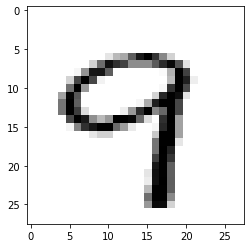

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Define a CNN for classification

In [8]:
class MnistClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, bias=False)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, stride=1, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(12*12*4, num_classes)
        
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

**Skip the following part and directly load a saved model given a few cells below.**

## Train a CNN for classification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
EPOCHS = 7
LEARNING_RATE = 0.001

model = MnistClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model.train()
for e in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        loss = criterion(y_pred_probs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        batch_acc = (y_pred == y_batch).sum().item()/BATCH_SIZE
        
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.5f}')    

## Save the model

In [ ]:
torch.save(model.state_dict(), "mnist_2_layer_cnn")

## Load Model (on CPU)

In [9]:
device = torch.device('cpu')
model = MnistClassifier()
model.load_state_dict(torch.load("mnist_2_layer_no_bias_cnn", map_location=device))

<All keys matched successfully>

In [10]:
print("Device: ", device)
params_before_pruning = sum(p.numel() for p in model.parameters())
print("\nParameters before pruning: ", params_before_pruning)

Device:  cpu

Parameters before pruning:  6130


## Test model 

In [11]:
y_pred_list = []
y_true_list = []

In [12]:
%%timeit

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

3.77 s ± 458 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(classification_report(y_true_list, y_pred_list))
print("\nParameters before pruning: ", params_before_pruning)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7840
           1       0.97      0.98      0.98      9080
           2       0.96      0.93      0.94      8256
           3       0.99      0.87      0.93      8080
           4       0.86      0.98      0.92      7856
           5       0.94      0.95      0.94      7136
           6       0.95      0.96      0.96      7664
           7       0.98      0.92      0.95      8224
           8       0.83      0.95      0.89      7792
           9       0.97      0.84      0.90      8072

    accuracy                           0.94     80000
   macro avg       0.94      0.94      0.94     80000
weighted avg       0.94      0.94      0.94     80000


Parameters before pruning:  6130


## Channel Pruning

In [14]:
class PruneModel():
    def __init__(self, cnn_model):
        self.cnn_model = cnn_model
        
    def get_model_layer_name(self, layer_type):
        if layer_type == "conv_weight":
            layer_names = [name for name, _ in self.cnn_model.named_parameters() if "conv" in name and "weight" in name]
        elif layer_type == "conv_bias":
            layer_names = [name for name, _ in self.cnn_model.named_parameters() if "conv" in name and "bias" in name]
            
        return layer_names
            
    
    def calc_filter_norm(self, conv_weight_layer_name_list):
        filter_norm_list = []
        
        for name, param in self.cnn_model.named_parameters():
            if name in conv_weight_layer_name_list:
                temp_conv_layer_norm_list = []
                for wt in param.data:
                    temp_conv_layer_norm_list.append(torch.norm(wt))
                filter_norm_list.append(temp_conv_layer_norm_list)
                    
        return filter_norm_list
        
    
    def worst_n_number_filters(self, norm_list, n):
        norm_array_list = [np.array(i) for i in norm_list]
        worst_norm_index_list = [list(np.argpartition(i, n))[:n] for i in norm_array_list]

        return worst_norm_index_list
    
    
    def remove_bad_filters(self, index_list, conv_weight_layer_name_list):
        num_filters_remove = len(index_list[0])
        
        for i, (name, param) in enumerate(self.cnn_model.named_parameters()):
            if name in conv_weight_layer_name_list:
                mask = torch.zeros_like(param.data).bool()
                for j in index_list[i]:
                    mask[j] = 1

                param.data = torch.masked_select(param.data, ~mask).view(param.data.shape[0]-num_filters_remove,
                                                                         param.data.shape[1],
                                                                         param.data.shape[2],
                                                                         param.data.shape[3])

        return self.cnn_model

In [15]:
prune_model = PruneModel(model)

conv_weight_layer_names = prune_model.get_model_layer_name(layer_type = "conv_weight")
print("conv_weight_layer_names:\n", conv_weight_layer_names)
# conv_bias_layer_names = prune_model.get_model_layer_name(layer_type = "conv_bias")
# conv_weight_bias_layer_names = conv_weight_layer_names+conv_bias_layer_names

norm_list = prune_model.calc_filter_norm(conv_weight_layer_names)
print("\nnorm_list:\n", norm_list)

index_list = prune_model.worst_n_number_filters(norm_list, 2)
print("\nindex_list:\n", index_list)


pruned_model = prune_model.remove_bad_filters(index_list, conv_weight_layer_names)

conv_weight_layer_names:
 ['conv1.weight', 'conv2.weight']

norm_list:
 [[tensor(16.5732), tensor(0.5417), tensor(15.6806), tensor(9.7491), tensor(18.3170), tensor(19.6589), tensor(19.1068), tensor(19.6257)], [tensor(50.5786), tensor(47.4790), tensor(44.8558), tensor(52.1951)]]

index_list:
 [[1, 3], [2, 1]]


In [16]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape, "\n", param.data)

conv1.weight torch.Size([6, 1, 3, 3]) 
 tensor([[[[-6.5707, -3.7024, -3.1393],
          [-5.2872, -5.7998, -5.7056],
          [-5.2720, -6.3201, -6.7859]]],


        [[[-1.6838, -0.4287, -0.1215],
          [-5.8476, -5.0102, -6.3054],
          [-6.9386, -6.8714, -6.9594]]],


        [[[-6.3545, -6.7356, -6.7520],
          [-4.6402, -6.4204, -6.7152],
          [-4.0202, -6.3933, -6.2684]]],


        [[[-6.7397, -6.7190, -6.9085],
          [-6.2247, -6.6597, -6.6372],
          [-6.7797, -6.5152, -5.7109]]],


        [[[-6.2283, -6.5689, -6.9430],
          [-6.4033, -6.9510, -6.4704],
          [-4.9063, -6.7165, -5.8785]]],


        [[[-6.8551, -6.8493, -6.8041],
          [-6.1269, -6.6609, -6.1992],
          [-6.6728, -6.2998, -6.3574]]]])
conv2.weight torch.Size([2, 8, 3, 3]) 
 tensor([[[[-5.7547e+00, -5.9268e+00, -6.4286e+00],
          [ 5.7408e+00, -6.4684e+00, -6.4968e+00],
          [ 3.4554e+00, -3.6581e+00, -5.1142e+00]],

         [[-2.6155e+00, -4.3112e-02,  1.

## Change model architecture

In [17]:
model.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, bias=False)
model.conv2 = nn.Conv2d(6, 2, kernel_size=3, stride=1, bias=False)
model.fc = nn.Linear(288, 10)

In [18]:
print("Device: ", device)
params_after_pruning = sum(p.numel() for p in model.parameters())

Device:  cpu


## Test accuracy of changed architecture

In [19]:
y_pred_list = []
y_true_list = []

In [20]:
%%timeit

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

3.55 s ± 92.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(classification_report(y_true_list, y_pred_list))
print("Parameters after pruning: ", params_after_pruning)

              precision    recall  f1-score   support

           0       0.06      0.03      0.04      7840
           1       0.13      0.36      0.19      9080
           2       0.00      0.00      0.00      8256
           3       0.08      0.00      0.01      8080
           4       0.00      0.00      0.00      7856
           5       0.00      0.00      0.00      7136
           6       0.03      0.14      0.05      7664
           7       0.03      0.01      0.02      8224
           8       0.15      0.25      0.19      7792
           9       0.00      0.00      0.00      8072

    accuracy                           0.08     80000
   macro avg       0.05      0.08      0.05     80000
weighted avg       0.05      0.08      0.05     80000

Parameters after pruning:  3052


/home/akshaj/miniconda3/envs/toothless/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Finetune Pruned Model (on GPU)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

EPOCHS = 3
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

model.to(device)
print(model)

cuda:0
MnistClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=288, out_features=10, bias=True)
)


In [23]:
model.train()
for e in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        loss = criterion(y_pred_probs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        batch_acc = (y_pred == y_batch).sum().item()/BATCH_SIZE
        
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.5f}')    

Epoch 00: | Loss: 0.32044 | Acc: 0.90577
Epoch 01: | Loss: 0.20870 | Acc: 0.94066
Epoch 02: | Loss: 0.19793 | Acc: 0.94261


## Test Accuracy of pruned model (on CPU)

In [24]:
device = "cpu"
model.to(device)

MnistClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv2): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=288, out_features=10, bias=True)
)

In [25]:
y_pred_list = []
y_true_list = []

In [28]:
%%timeit 

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

3.64 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(classification_report(y_true_list, y_pred_list))
print("Parameters after pruning: ", params_after_pruning)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     15680
           1       0.98      0.99      0.99     18160
           2       0.95      0.94      0.94     16512
           3       0.95      0.95      0.95     16160
           4       0.93      0.97      0.95     15712
           5       0.91      0.95      0.93     14272
           6       0.97      0.96      0.96     15328
           7       0.89      0.95      0.92     16448
           8       0.96      0.88      0.92     15584
           9       0.94      0.89      0.91     16144

    accuracy                           0.95    160000
   macro avg       0.95      0.94      0.94    160000
weighted avg       0.95      0.95      0.95    160000

Parameters after pruning:  3052
